# **S-PLM v2: Quickstart**

This notebook is a **usage example** of **S-PLM v2**.

* **Purpose:**

    1. Process PDB structures into the standardized inputs expected by our model.
    
    2. Generate **protein-level** and **residue-level** embeddings.
    
    3. Run sample evaluations and export metrics/logs.
* **Checkpoint:** An S-PLM v2 `.pth` checkpoint. Download from the provided [SharePoint link](https://mailmissouri-my.sharepoint.com/:u:/g/personal/wangdu_umsystem_edu/EUZ74fO3NOxHjTvc6uvKwDsB5fELaaw-oiPHFU9CJky_hg?e=4phwL0).



### **Environment Setup**

We **recommend** using an NVIDIA **A100** in Colab; other GPUs/CPU will work but may be slower or run into memory limits.


In [ ]:
# Clone S-PLM
!git clone -q https://github.com/Yichuan0712/SPLM-V2-GVP /content/SPLMv2

# Install minimal deps
!pip install 'git+https://github.com/facebookresearch/esm.git' -q
!pip install 'git+https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup' -q
!pip install biopython -q

In [ ]:
import torch
TORCH = torch.__version__.split('+')[0]
CUDA = 'cu' + torch.version.cuda.replace('.', '')
whl_url = f'https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html'
print("Using wheel URL:", whl_url)
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric \
    -f {whl_url} -q

### **Prepare Checkpoint**

1. **Download the model** from the provided **[SharePoint link](https://mailmissouri-my.sharepoint.com/:u:/g/personal/wangdu_umsystem_edu/EUZ74fO3NOxHjTvc6uvKwDsB5fELaaw-oiPHFU9CJky_hg?e=4phwL0)** to your local machine.
2. **Upload to your Colab runtime** (Files pane → Upload to session storage), then set:




In [ ]:
CHECKPOINT_PATH = "/content/checkpoint_0280000_gvp.pth"

3. **Faster option (recommended):** Mount Google Drive and copy the checkpoint from Drive into the Colab runtime.


In [ ]:
from google.colab import drive, files
import os, shutil
drive.mount('/content/drive', force_remount=True)
shutil.copy("/content/drive/MyDrive/checkpoint_0280000_gvp.pth",
            "/content/checkpoint_0280000_gvp.pth")
CHECKPOINT_PATH = "/content/checkpoint_0280000_gvp.pth"

Mounted at /content/drive


### **Preprocess PDB**

First preprocess your PDB files using the provided script; only the resulting HDF5 files can be fed into the S-PLM v2 GVP model.


In [ ]:
!python /content/SPLMv2/data/preprocess_pdb.py --data /content/SPLMv2/dataset/CATH_4_3_0_non-rep_pdbs/ --save_path /content/CATH_4_3_0_non-rep_gvp/ --max_workers 4

### **Generate Structure Embeddings**

Use GVP model to produce **residue-level structure embeddings** from **preprocessed HDF5** inputs and save them to `protein_struct_embeddings.pkl`, then quickly print the loaded result for inspection.

**Inputs:** `--hdf5_path` (preprocessed data), `--config_path`, `--checkpoint_path`.

**Output:** `protein_struct_embeddings.pkl` in the current directory (embeddings per protein/chain).

**Note:** You **must preprocess** PDB first, the model only accepts the processed HDF5 tensors.


In [ ]:
import os
os.chdir('/content/SPLMv2')
!python -m utils.generate_struct_embedding \
  --hdf5_path /content/CATH_4_3_0_non-rep_gvp/ \
  --config_path /content/SPLMv2/configs/config_plddtallweight_noseq_rotary_foldseek.yaml \
  --checkpoint_path /content/checkpoint_0280000_gvp.pth \
  --result_path ./ \
  --residue_level

import pickle
with open('protein_struct_embeddings.pkl', 'rb') as f:
    print(pickle.load(f))

### **Generate Sequence Embeddings**

Use GVP model to generate embeddings from FASTA sequences, with optional truncation and residue-level outputs.

* **Standard run:** produces **protein-level** embeddings from `.fasta` to `.pkl`
* **Truncated run:** sets `--truncate_inference 1 --max_length_inference 1022` to handle long sequences

* **Residue-level run:** adds `--residue_level`

**Inputs:** `--input_seq` (FASTA), `--config_path`, `--checkpoint_path`.

**Outputs:** pickled embeddings in the working directory (per protein or per residue, depending on flags).


In [ ]:
import os
os.chdir('/content/SPLMv2')

# standard run
!python3 -m utils.generate_seq_embedding --input_seq /content/SPLMv2/dataset/protein.fasta \
  --config_path /content/SPLMv2/configs/config_plddtallweight_noseq_rotary_foldseek.yaml \
  --checkpoint_path /content/checkpoint_0280000_gvp.pth \
  --result_path ./

In [ ]:
import os
os.chdir('/content/SPLMv2')

# truncate_inference with max_length_inference=1022
!python3 -m utils.generate_seq_embedding --input_seq /content/SPLMv2/dataset/protein.fasta \
--config_path /content/SPLMv2/configs/config_plddtallweight_noseq_rotary_foldseek.yaml \
--checkpoint_path /content/checkpoint_0280000_gvp.pth \
--result_path ./ --out_file truncate_protein_embeddings.pkl \
--truncate_inference 1 --max_length_inference 1022

import pickle
with open('truncate_protein_embeddings.pkl', 'rb') as f:
    data = pickle.load(f)

In [ ]:
import os
os.chdir('/content/SPLMv2')

# residue_level representations
!python3 -m utils.generate_seq_embedding --input_seq /content/SPLMv2/dataset/protein.fasta \
--config_path /content/SPLMv2/configs/config_plddtallweight_noseq_rotary_foldseek.yaml \
--checkpoint_path /content/checkpoint_0280000_gvp.pth \
--result_path ./ --out_file truncate_protein_residue_embeddings.pkl \
--truncate_inference 1 --max_length_inference 1022 --residue_level

import pickle
with open('truncate_protein_residue_embeddings.pkl', 'rb') as f:
    data = pickle.load(f)

### **Evaluate on CATH**

Build the GVP model structure model, run **CATH** evaluation with preprocessed HDF5 inputs, and save metrics/figures.
**Inputs:** `checkpoint_path`, `config_path`, and `cathpath` pointing to the **preprocessed** CATH HDF5 directory.

**What it does:**

* Instantiates `StructRepresentModel` and sets `out_figure_path`.
* Calls `evaluate_with_cath_more_struct(...)` (batch_size=1) to compute clustering/quality metrics (digit-1/2/3, ARI, silhouette).
* Prints scores to stdout and writes a summary to `scores.txt` under `out_figure_path`.

**Note:** CATH structures must be **preprocessed to HDF5** first (raw PDB won’t be accepted).


/content/SPLMv2/gvp/models.py:339: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Automatically handles FP16 and FP32 operations
/content/SPLMv2/model.py:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Automatically handles FP16 and FP32 operations


seq_embeddings  = (1553, 100)
sample num=1553
sample num=1049
sample num=306
gvp_digit_num_1:1265.8002(2226.8755)	gvp_digit_num_2:395.9138(700.9312)	gvp_digit_num_3:164.9577(290.0055)

gvp_digit_num_1_ARI:0.5721332636871217	gvp_digit_num_2_ARI:0.33269029939921524	gvp_digit_num_3_ARI:0.4896523190733887

gvp_digit_num_1_silhouette:0.3151196837425232	gvp_digit_num_2_silhouette:0.11235411465167999	gvp_digit_num_3_silhouette:0.12095800042152405



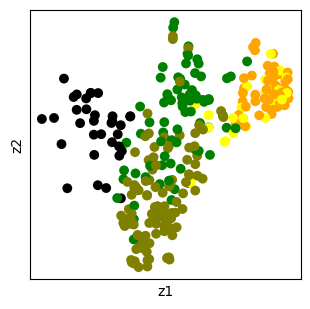

In [ ]:
import os
os.chdir('/content/SPLMv2')
from pathlib import Path
from utils.generate_struct_embedding import StructRepresentModel
from cath_with_struct import evaluate_with_cath_more_struct

checkpoint_path = "/content/checkpoint_0280000_gvp.pth"
config_path = "/content/SPLMv2/configs/config_plddtallweight_noseq_rotary_foldseek.yaml"
model, device, configs = StructRepresentModel(config_path=config_path, checkpoint_path=checkpoint_path)
out_figure_path = os.path.join(config_path.split(".yaml")[0], "CATH_test_release")
Path(out_figure_path).mkdir(parents=True, exist_ok=True)
cathpath = "/content/CATH_4_3_0_non-rep_gvp/"
scores_cath = evaluate_with_cath_more_struct(
    out_figure_path,
    device=device,
    batch_size=1,
    model=model,
    cathpath=cathpath,
    configs=configs
    )
print(f"gvp_digit_num_1:{scores_cath[0]:.4f}({scores_cath[1]:.4f})\tgvp_digit_num_2:{scores_cath[4]:.4f}({scores_cath[5]:.4f})\tgvp_digit_num_3:{scores_cath[8]:.4f}({scores_cath[9]:.4f})\n")
print(f"gvp_digit_num_1_ARI:{scores_cath[2]}\tgvp_digit_num_2_ARI:{scores_cath[6]}\tgvp_digit_num_3_ARI:{scores_cath[10]}\n")
print(f"gvp_digit_num_1_silhouette:{scores_cath[3]}\tgvp_digit_num_2_silhouette:{scores_cath[7]}\tgvp_digit_num_3_silhouette:{scores_cath[11]}\n")

with open(os.path.join(out_figure_path, 'scores.txt'), 'w') as file:
    file.write(f"gvp_digit_num_1:{scores_cath[0]:.4f}({scores_cath[1]:.4f})\tgvp_digit_num_2:{scores_cath[3]:.4f}({scores_cath[4]:.4f})\tgvp_digit_num_3:{scores_cath[6]:.4f}({scores_cath[7]:.4f})\n")
    file.write(f"gvp_digit_num_1_ARI:{scores_cath[2]}\tgvp_digit_num_2_ARI:{scores_cath[5]}\tgvp_digit_num_3_ARI:{scores_cath[8]}\n")
    file.write(f"gvp_digit_num_1_silhouette:{scores_cath[3]}\tgvp_digit_num_2_silhouette:{scores_cath[7]}\tgvp_digit_num_3_silhouette:{scores_cath[11]}\n")
